In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from os import listdir
from os.path import isfile, isdir
from math import factorial
from colorama import Fore, Back, Style

from run.utils import load_parameters, load_data, load_all

In [2]:
plt.rcParams.update({'font.size': 13})
protein_name = '1PGB'

---
### PFAM alignement K-sites combinations

In [3]:
site_weights = np.load('run/inputs/site_weights.npy')
mask = site_weights == 1.
num_Ksites = mask.sum().astype(int)
d_start = f'results/{protein_name}'

with open(f'results/{protein_name}/{protein_name}_alignement.txt', 'r') as f:
    lines = f.readlines()
alignement = [line.split('\t')[-1][:-1] for line in lines]
Ksites_alignement = [''.join(np.array(list(sequence))[mask]) for sequence in alignement if not '-' in sequence]
Ksites_alignement, alignement_counts = np.unique(Ksites_alignement, return_counts = True)
wt_index = np.argmax(alignement_counts)

print('PFAM alignement K-sites combinations and frequencies:\n')
for idx, (Ksites, count) in enumerate(zip(Ksites_alignement, alignement_counts)):
    if idx == wt_index: suffix = '(1PGB)'
    else: suffix = ''
    print(f'{Ksites}\t\t{format(100 * count/alignement_counts.sum(), ".1f")}%\t{suffix}')
print()

PFAM alignement K-sites combinations and frequencies:

FGAFFWA		0.9%	
FGAFLWA		1.8%	
FGAFLWG		0.9%	
FIAFAFY		1.8%	
FIAFLYY		1.8%	
LGAFFWA		2.6%	
LGAFGWV		81.6%	(1PGB)
LGAFLWA		6.1%	
LIAFLWA		1.8%	
LIAFLWV		0.9%	



---
### Quench simulations results

In [4]:
def calculate_Haming_distance(sequence_a, sequence_b):
    array_a = np.array(list(sequence_a))
    array_b = np.array(list(sequence_b))
    new_residues_idxs = np.where(array_a != array_b)[0]
    Hamm_distance = len(new_residues_idxs)
    return Hamm_distance

In [5]:
d_start = f'results/{protein_name}'
raw_dirlist = np.array([d for d in listdir(f'{d_start}') if isdir(f'{d_start}/{d}') and (not '.ipynb' in d)])
seeds = np.array([int(d[1:]) for d in raw_dirlist])
sort_seeds = np.sort(seeds)

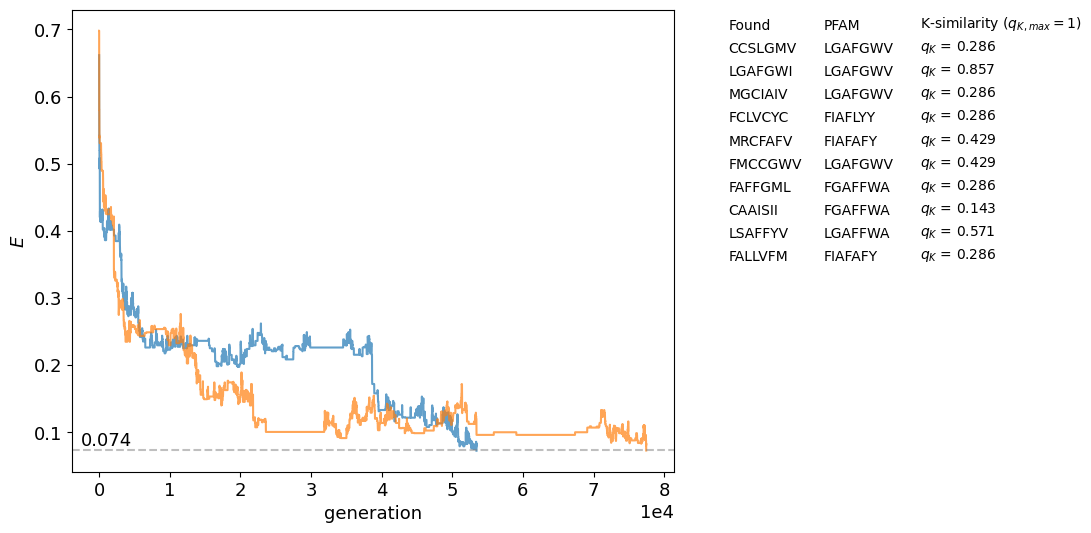

In [6]:
shown_seeds = [-2, -4]
good_seeds = sort_seeds
check = np.all([seed in good_seeds for seed in shown_seeds])
assert check, '<shown_seeds> must be included in <good_seeds>.'


fig, axs = plt.subplots(figsize = (12, 6), nrows = 1, ncols = 3)
gs = axs[0].get_gridspec()
for ax in axs[:-1]:
    ax.remove()
big_ax = fig.add_subplot(gs[:-1])
sml_ax = axs[-1]


dirlist = [raw_dirlist[seeds == seed][0] for seed in good_seeds]
for id, d in enumerate(dirlist):
    actual_d = f'{d_start}/{d}' 
    data, parameters = load_all(actual_d) 
    generations = parameters['generation']
    seed = np.unique(parameters['seed'])
    assert len(seed) == 1, 'Too many values for "seed" quantity.'

    # SEQUENCES K-SITES
    if not seed in good_seeds: continue
    last_sequence = data['sequences'][-1]
    Ksites_last_sequence= np.array([''.join(np.array(list(last_sequence))[mask])])[0]

    alignement_distances = []
    for Ksites in Ksites_alignement:
        distance = calculate_Haming_distance(Ksites_last_sequence, Ksites)
        alignement_distances.append(distance)
    q_K = (num_Ksites - np.min(alignement_distances)) / num_Ksites
    most_sim_Ksites = Ksites_alignement[np.argmin(alignement_distances)]
    
    ax = sml_ax
    if id == 0:
        annotations = ['Found', 'PFAM', r'K-similarity ($q_{K, max} = 1$)']
        for iann, annotation in enumerate(annotations):
            ax.annotate(annotation,
                    xy=(iann * 0.35, 1.-(id + 1)/20.),
                    xytext=(0, 0),
                    rotation=0,
                    textcoords='offset points',
                    ha='left', va='bottom',
                    fontsize = 10
            )
    annotations = [f'{"".join(Ksites_last_sequence)}', f'{most_sim_Ksites}', r'$q_{K}$ = ' + f'{format(q_K, ".3f")}']
    for iann, annotation in enumerate(annotations):
        ax.annotate(annotation,
                xy=(iann * 0.35, 1.-(id + 2)/20.),
                xytext=(0, 0),
                rotation=0,
                textcoords='offset points',
                ha='left', va='bottom',
                fontsize = 10
        )

    # DATA PLOTTING
    if not seed in shown_seeds: continue
    label = f'seed {seed[0]}'

    ax = big_ax
    ax.plot(generations, data['energies'], alpha = 0.7)


ax = big_ax
ax.set_ylabel(r'$E$')
ax.set_xlabel(r'generation')
ax.ticklabel_format(axis = 'x', style = 'sci', scilimits = (4, 4))
#ax.legend(loc = 'upper right')

ax = sml_ax
ax.axis('off')


ax = big_ax
with open(f'{d_start}/{dirlist[0]}/Tgt_file.txt', 'r') as f:
    lines = f.readlines()
assert len(lines) == 1, f'Unexpected number of lines for quench algorithm. Expected 1, Found {len(lines)}.'
T, gamma, threshold = float(lines[0].split('\t')[0]), float(lines[0].split('\t')[1]), float(lines[0].split('\t')[2])
ax.axhline(threshold, linestyle = '--', color = 'grey', alpha = 0.5)
ax.annotate(format(threshold, ".3f"),
            xy=(0, threshold),
            xytext=(5, 0),
            rotation=0,
            textcoords='offset points',
            ha='center', va='bottom',
            fontsize = 13
)


plt.subplots_adjust(hspace = 0.1)
plt.savefig(f'plots/Quench_Ksites.png', bbox_inches='tight');

---
### Reaching PFAM

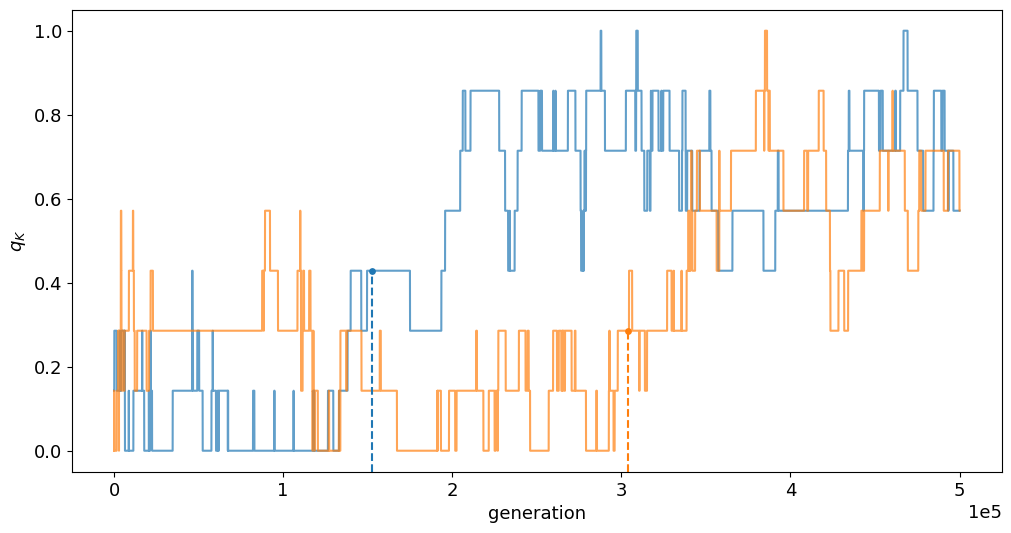

In [28]:
Ksites_alignement_array = np.array([list(s) for s in Ksites_alignement])
shown_seeds = [1, 3]
threshold = 0.0736774104006049

fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(1, 1, 1)

vlines_pars = []
for i in np.arange(5) + 1:
    if not i in shown_seeds: continue
    d = f'results/raw/s-{i}'
    data, parameters = load_all(d) 
    generations = parameters['generation']
    
    # SEQUENCES K-SITES
    sequences = np.array([list(sequence) for sequence in data['sequences']])
    Ksites_sim = sequences[:, mask]
    qK = 1. - np.array([(Ksites != Ksites_alignement_array).astype(int).sum(axis = 1).min()/num_Ksites for Ksites in Ksites_sim])
    ax.plot(generations, qK, alpha = 0.7)
    color = ax.get_lines()[-1].get_color()

    tmask = data['energies'] < threshold
    vlines_pars.append((generations[tmask][0], qK[tmask][0], color))

ymin, yspan = ax.get_ylim()[0], np.diff(ax.get_ylim())[0]
for vline_pars in vlines_pars:
    (g, q, c) = vline_pars
    ax.axvline(g, ymax = (q - ymin)/yspan, linestyle = '--', color = f'{c}')
    ax.scatter([g], [q], color = f'{c}', marker = 'o', s = 15)

ax.set_xlabel('generation')
ax.set_ylabel(r'$q_K$')
ax.ticklabel_format(axis = 'x', style = 'sci', scilimits = (5, 5))

plt.savefig(f'plots/Quench_Ksites_convergence.png', bbox_inches='tight');

---
---
---
### Data copy

In [11]:
raw_dirlist = np.array([f'results/raw/{d}' for d in listdir('results/raw') if isdir(f'results/raw/{d}') and ('SM' in d)])
seeds = [int(d.split('_')[-3].split('-')[-1][-1]) for d in raw_dirlist]
for i in range(len(seeds)):
    d = raw_dirlist[seeds.index(i + 1)]
    with open(f'{d}/s0/data_T0.0032_g0.0_s0.dat', 'r') as df:
        ddf = pd.read_csv(df, sep = '\t', names = ['generation', 'energy', 'dG', 'dPAM', 'dHamm', 'ar', 'T', 'gamma', 'length'])
    ddf['dPAM'] = ddf['dPAM'] / ddf['length']
    ddf['dHamm'] = ddf['dHamm'] / ddf['length']
    with open(f'{d}/s0/mutants_T0.0032_g0.0_s0.dat', 'r') as df:
        mdf = pd.read_csv(df, sep = '\t', names = ['generation', 'sequence'])
    data = pd.DataFrame({
        'generation': ddf['generation'].astype(int),
        'sequence': mdf['sequence'],
        'energy': ddf['energy'],
        'dPAM': ddf['dPAM'], 
        'dHamm': ddf['dHamm'],
        'ar': ddf['ar']
    })
    data = np.array(data)
    with open(f'results/raw/s{-(i+1)}/data.dat', 'w') as df:
        for line in data:
            printed_line = ''
            for el in line:
                printed_line = printed_line + f'\t{el}'
            print(printed_line[1:], file = df)
    parameters = pd.DataFrame({
        'generation': ddf['generation'].astype(int),
        'T': ddf['T'],
        'gamma': ddf['gamma'],
        'threshold': [0.0736774104006049] * len(ddf['generation']), 
        'seed': [-(i+1)] * len(ddf['generation']),
        'length': ddf['length']
    })
    parameters = np.array(parameters)
    with open(f'results/raw/s{-(i+1)}/parameters.dat', 'w') as df:
        for line in parameters:
            printed_line = ''
            for el in line:
                printed_line = printed_line + f'\t{el}'
            print(printed_line[1:], file = df)